In [2]:
print(type(load_profile))

<class 'list'>



Solving MILP optimization model with piecewise efficiency (Cost minimization)...
Optimization horizon: 1 day(s) with 60-minute resolution
Total time steps: 24
Optimal solution found! Total cost: 86820.36 INR


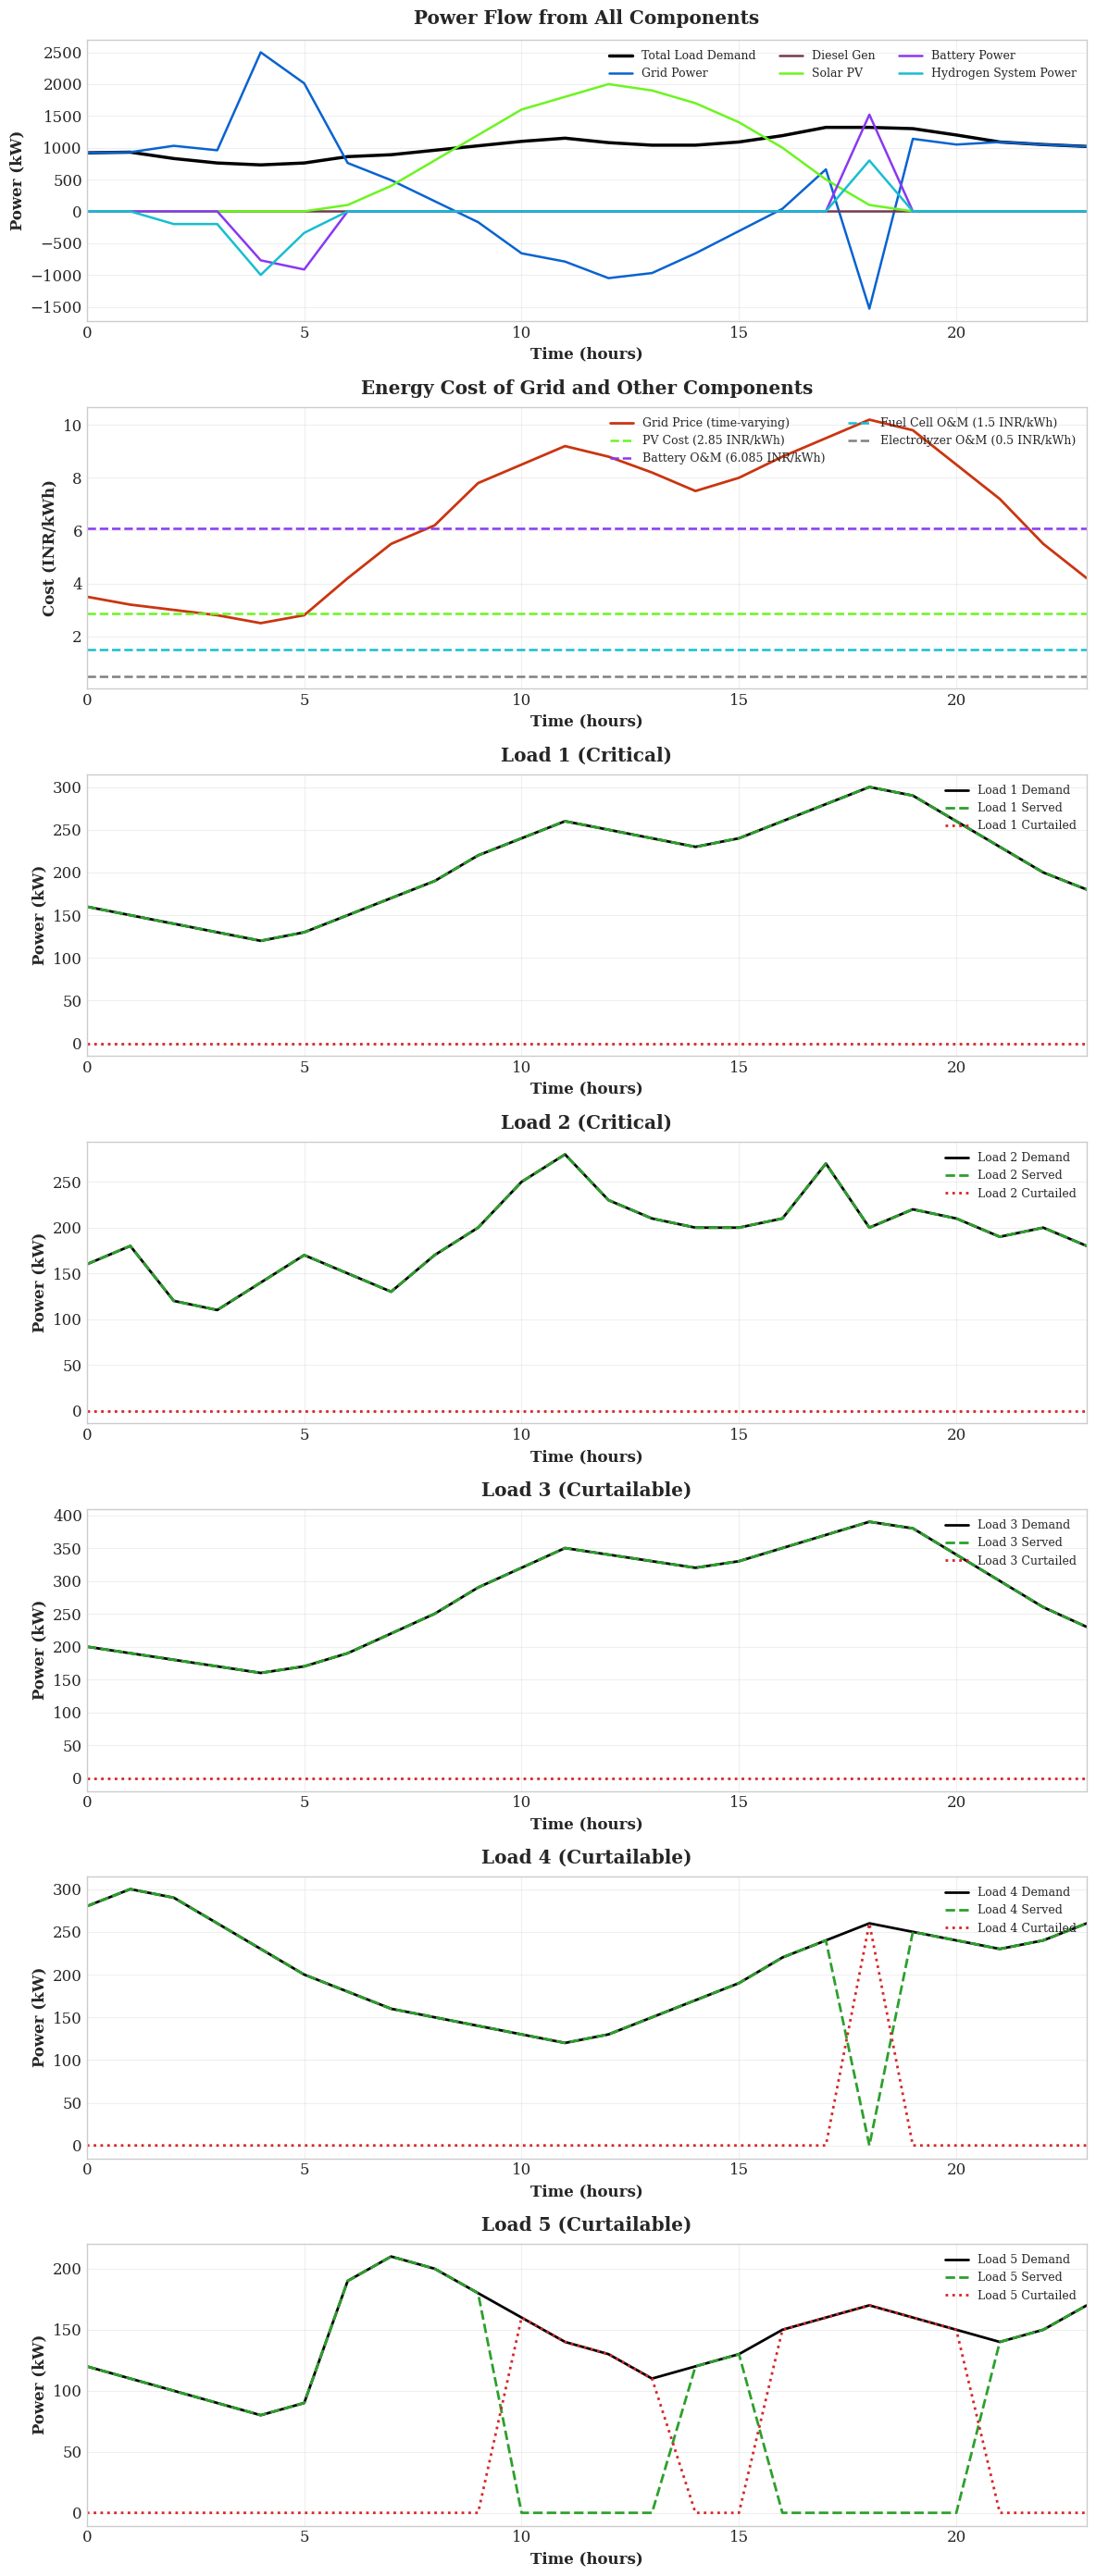


                      ENERGY SYSTEM SUMMARY REPORT
Optimization Period: 1 day(s)
Time Resolution: 60 minutes
Total Time Steps: 24

LOAD ANALYSIS:
  Total Load Demand:         24660.0 kWh
  Total Load Served:         23070.0 kWh (93.6%)
  Total Load Curtailed:       1590.0 kWh

  Load 1 [CRITICAL]:
     Demand:      5020.0 kWh
     Served:      5020.0 kWh (100.0%)
     Curtailed:      0.0 kWh

  Load 2 [CRITICAL]:
     Demand:      4580.0 kWh
     Served:      4580.0 kWh (100.0%)
     Curtailed:      0.0 kWh

  Load 3 [DR (Curtailable)]:
     Demand:      6630.0 kWh
     Served:      6630.0 kWh (100.0%)
     Curtailed:      0.0 kWh

  Load 4 [DR (Curtailable)]:
     Demand:      5020.0 kWh
     Served:      4760.0 kWh (94.8%)
     Curtailed:    260.0 kWh

  Load 5 [DR (Curtailable)]:
     Demand:      3410.0 kWh
     Served:      2080.0 kWh (61.0%)
     Curtailed:   1330.0 kWh

GRID ANALYSIS:
  Grid Import:               15812.5 kWh
  Grid Export:                6139.2 kWh

DIESEL GENE

In [ ]:
# %%
import matplotlib.pyplot as plt
from pulp import *
import numpy as np
import pandas as pd


# %%
# =============================================================================
# USER CONFIGURABLE PARAMETERS
# =============================================================================


# Optimization Time Parameters
num_days = 1                    # Number of days to optimize
time_resolution_minutes = 60    # Time step in minutes (e.g., 15, 30, 60)

# System connection parameters
grid_connection = 2500      # Grid connection capacity [kW]
solar_connection = 2000     # Solar connection capacity [kW]
battery_capacity = 40000    # Battery capacity [Ah]
battery_voltage = 100       # Battery voltage [V]
diesel_capacity = 2200      # Diesel generator capacity [kW]
fuel_price = 90             # INR per liter

# Hydrogen System Parameters
electrolyzer_capacity = 1000  # Max power consumption of the electrolyzer [kW]
fuel_cell_capacity = 1000      # Max power generation of the fuel cell [kW]
h2_tank_capacity = 100        # Hydrogen storage tank capacity [kg]
fuel_cell_efficiency_percent = 0.60 # Fuel cell DC electrical efficiency (60%)

# Cost parameters
pv_energy_cost = 2.85               # PV energy cost [INR/kWh]
battery_om_cost = 6.085             # Battery O&M cost [INR/kWh]
fuel_cell_om_cost = 1.5             # Fuel cell O&M cost [INR/kWh]
electrolyzer_om_cost = 0.5          # Electrolyzer O&M cost [INR/kWh]

# ============================
# CO2 EMISSION PARAMETERS
# ============================
co2_grid_import = 0.82
co2_diesel = 0.27
co2_battery_discharge = 0.02
co2_pv_used = 0.05
co2_fuel_cell = 0.0
co2_electrolyzer = 0.0

# ==== Curtailment penalties per non-critical load ====
curtail_penalty = {
    3: 18.0,   # INR/kWh (high priority)
    4: 10.0,    # INR/kWh (medium priority)
    5: 8.0     # INR/kWh (low priority)
}

# Weather condition selection
weather_condition = 1  # 1 = Sunny, 2 = Rainy

# Base total load and price profiles (24-hour)
# load_profile_24h = [800, 750, 700, 650, 600, 650, 750, 850, 950, 1100, 1200, 1300,
#                     1250, 1200, 1150, 1200, 1300, 1400, 1500, 1450, 1300, 1150, 1000, 900]

# ======================
# FIVE FIXED LOAD PROFILES (24h)
# ======================

# Critical Load 1 (Base hospital load)
load1_24h = [
 160,150,140,130,120,130,150,170,190,220,240,260,
 250,240,230,240,260,280,300,290,260,230,200,180
]

# Critical Load 2 (Server / IT)
load2_24h = [
 160,180,120,110,140,170,150,130,170,200,250,280,
 230,210,200,200,210,270,200,220,210,190,200,180
]

# DR Load 3 (High Priority – office lighting & HVAC)
load3_24h = [
 200,190,180,170,160,170,190,220,250,290,320,350,
 340,330,320,330,350,370,390,380,340,300,260,230
]

# DR Load 4 (Medium Priority – residential)
load4_24h = [
 280,300,290,260,230,200,180,160,150,140,130,120,130,150,170,190,220,240,260,
 250,240,230,240,260
]

# DR Load 5 (Low Priority – EV/Flexible)
load5_24h = [
 120,110,100,90,80,90,190,210,200,180,160,140,130,110,120,130,150,160,170,
 160,150,140,150,170,
]


price_profile_24h = [3.5, 3.2, 3.0, 2.8, 2.5, 2.8, 4.2, 5.5, 6.2, 7.8, 8.5, 9.2,
                     8.8, 8.2, 7.5, 8.0, 8.8, 9.5, 10.2, 9.8, 8.5, 7.2, 5.5, 4.2]



# =============================================================================
# FIXED PARAMETERS AND MODEL SETUP
# =============================================================================

step_size = time_resolution_minutes / 60.0
steps_per_hour = int(60 / time_resolution_minutes)
time_horizon = num_days * 24 * steps_per_hour


def upsample_profile(hourly_profile, steps_per_hour, num_days):
    """Upsample hourly profile using linear interpolation."""
    hourly_times = np.arange(len(hourly_profile))
    fine_times = np.linspace(0, len(hourly_profile) - 1,
                             len(hourly_profile) * steps_per_hour)
    upsampled_single_day = np.interp(fine_times, hourly_times, hourly_profile).tolist()
    return upsampled_single_day * num_days



# Central physical constant
H2_LHV = 33.3  # kWh/kg

# Diesel generator parameters
diesel_min_power = 0.1 * diesel_capacity
diesel_max_power = diesel_capacity
fuel_slope, fuel_intercept = 0.18, 48

# Battery parameters
battery_storage_energy = (battery_capacity * battery_voltage) / 1000
battery_power = battery_storage_energy * 0.5

# Solar profiles
solar_profile_sunny = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 0.9,
                       1.0, 0.95, 0.85, 0.7, 0.5, 0.25, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0]
solar_profile_rainy = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25,
                       0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

if weather_condition == 1:
    solar_profile_base = solar_profile_sunny
    weather_type = "Sunny Day"
else:
    solar_profile_base = solar_profile_rainy
    weather_type = "Rainy Day"

# ==== Use new multi-load generator ====
load_ids = [1, 2, 3, 4, 5]
critical_loads = [1, 2]
dr_loads = [3, 4, 5]

# Upsample all five profiles
load_profiles = {
    1: upsample_profile(load1_24h, steps_per_hour, num_days),
    2: upsample_profile(load2_24h, steps_per_hour, num_days),
    3: upsample_profile(load3_24h, steps_per_hour, num_days),
    4: upsample_profile(load4_24h, steps_per_hour, num_days),
    5: upsample_profile(load5_24h, steps_per_hour, num_days),
}

# Total load (for plotting)
load_profile = [
    load_profiles[1][t] +
    load_profiles[2][t] +
    load_profiles[3][t] +
    load_profiles[4][t] +
    load_profiles[5][t]
    for t in range(time_horizon)
]

price_profile = upsample_profile(price_profile_24h, steps_per_hour, num_days)
solar_profile = upsample_profile(solar_profile_base, steps_per_hour, num_days)

# System Capacities
grid_max_power = grid_connection
solar_capacity = solar_connection
bess_charge_capacity = bess_discharge_capacity = battery_power
bess_energy_capacity = battery_storage_energy
bess_min_soc, bess_max_soc = 0.1, 0.9
bess_charge_efficiency, bess_discharge_efficiency = 0.95, 0.95

# Hydrogen System Parameters
h2_min_soc, h2_max_soc = 0.1, 0.9
fuel_cell_efficiency_kwh_per_kg = H2_LHV * fuel_cell_efficiency_percent
fc_conversion_rate = 1 / fuel_cell_efficiency_kwh_per_kg

# =============================================================================
# PIECEWISE LINEAR ELECTROLYZER PARAMETERS
# =============================================================================

P_break1_percent = 0.20
eff_at_break1 = 0.80
eff_at_break2 = 0.75

P_break1 = electrolyzer_capacity * P_break1_percent
P_break2 = electrolyzer_capacity

H2_at_break1 = (P_break1 * 1 * eff_at_break1) / H2_LHV
H2_at_break2 = (P_break2 * 1 * eff_at_break2) / H2_LHV

slope_s1 = H2_at_break1 / P_break1 if P_break1 > 0 else 0
slope_s2 = (H2_at_break2 - H2_at_break1) / (P_break2 - P_break1) if (P_break2 - P_break1) > 0 else 0

width_s1 = P_break1
width_s2 = P_break2 - P_break1

# =============================================================================
# OPTIMIZATION SETUP
# =============================================================================

bess_min_level, bess_max_level = bess_min_soc * bess_energy_capacity, bess_max_soc * bess_energy_capacity
h2_min_level, h2_max_level = h2_min_soc * h2_tank_capacity, h2_max_soc * h2_tank_capacity

model = LpProblem('Energy_System_Optimization', LpMinimize)
T = range(time_horizon)

# Decision Variables
P_grid = {t: LpVariable(f"P_grid_{t}", -grid_max_power, grid_max_power) for t in T}
P_diesel = {t: LpVariable(f"P_diesel_{t}", 0, diesel_max_power) for t in T}
z_diesel = {t: LpVariable(f"z_diesel_{t}", cat='Binary') for t in T}
F_diesel = {t: LpVariable(f"F_diesel_{t}", 0) for t in T}
P_charge = {t: LpVariable(f"P_charge_{t}", 0, bess_charge_capacity) for t in T}
P_discharge = {t: LpVariable(f"P_discharge_{t}", 0, bess_discharge_capacity) for t in T}
E_battery = {t: LpVariable(f"E_battery_{t}", bess_min_level, bess_max_level) for t in T}
z_bess = {t: LpVariable(f"z_bess_{t}", cat='Binary') for t in T}
P_pv_used = {t: LpVariable(f"P_pv_used_{t}", 0) for t in T}
P_solar_curt = {t: LpVariable(f"P_solar_curt_{t}", 0) for t in T}

# Hydrogen system variables
P_elec = {t: LpVariable(f"P_elec_{t}", 0, electrolyzer_capacity) for t in T}
P_fc = {t: LpVariable(f"P_fc_{t}", 0, fuel_cell_capacity) for t in T}
E_h2 = {t: LpVariable(f"E_h2_{t}", h2_min_level, h2_max_level) for t in T}
z_h2 = {t: LpVariable(f"z_h2_{t}", cat='Binary') for t in T}

# Piecewise electrolyzer
P_elec_s1 = {t: LpVariable(f"P_elec_s1_{t}", 0, width_s1) for t in T}
P_elec_s2 = {t: LpVariable(f"P_elec_s2_{t}", 0, width_s2) for t in T}
z_elec_s2 = {t: LpVariable(f"z_elec_s2_{t}", cat='Binary') for t in T}
H_produced = {t: LpVariable(f"H_produced_{t}", 0) for t in T}

# Served / curtailed loads
P_served = {(i, t): LpVariable(f"P_served_L{i}_{t}", 0) for i in load_ids for t in T}
P_curt = {(i, t): LpVariable(f"P_curt_L{i}_{t}", 0) for i in dr_loads for t in T}

# =============================================================================
# CONSTRAINTS
# =============================================================================

# Load constraints
for t in T:
    # Critical loads: must be fully served
    for i in critical_loads:
        model += P_served[(i, t)] == load_profiles[i][t], f"crit_load_{i}_served_{t}"
    # Non-critical: served + curtailed = demand
    for i in dr_loads:
        model += P_served[(i, t)] + P_curt[(i, t)] == load_profiles[i][t], f"dr_load_{i}_balance_{t}"

# Power balance
for t in T:
    total_served_load = sum(P_served[(i, t)] for i in load_ids)
    supply = P_pv_used[t] + P_diesel[t] + P_discharge[t] + P_grid[t] + P_fc[t]
    demand = total_served_load + P_charge[t] + P_elec[t]
    model += (supply == demand), f"power_balance_{t}"

# Solar
for t in T:
    solar_available = solar_profile[t] * solar_capacity
    model += P_pv_used[t] + P_solar_curt[t] == solar_available, f"pv_balance_{t}"

# Diesel
for t in T:
    model += P_diesel[t] >= diesel_min_power * z_diesel[t], f"diesel_min_{t}"
    model += P_diesel[t] <= diesel_max_power * z_diesel[t], f"diesel_max_{t}"
    model += F_diesel[t] >= fuel_slope * P_diesel[t] + fuel_intercept * z_diesel[t], f"fuel_cons_{t}"

# Battery
initial_battery_level = 0.5 * bess_energy_capacity
model += E_battery[0] == initial_battery_level
for t in T:
    if t < time_horizon - 1:
        model += (E_battery[t+1] == E_battery[t] +
                  step_size * (P_charge[t] * bess_charge_efficiency -
                               P_discharge[t] * (1 / bess_discharge_efficiency))), f"battery_dynamics_{t}"
    model += P_charge[t] <= bess_charge_capacity * (1 - z_bess[t]), f"charge_limit_{t}"
    model += P_discharge[t] <= bess_discharge_capacity * z_bess[t], f"discharge_max_{t}"

model += (initial_battery_level == E_battery[time_horizon-1] +
          step_size * (P_charge[time_horizon-1] * bess_charge_efficiency -
                       P_discharge[time_horizon-1] * (1 / bess_discharge_efficiency))), "final_battery_level_cyclic"

# Hydrogen system
initial_h2_level = 0.5 * h2_tank_capacity
model += E_h2[0] == initial_h2_level

for t in T:
    model += P_elec[t] == P_elec_s1[t] + P_elec_s2[t], f"elec_power_sum_{t}"
    model += H_produced[t] == (P_elec_s1[t] * slope_s1) + (P_elec_s2[t] * slope_s2), f"h2_production_calc_{t}"
    model += P_elec_s1[t] >= width_s1 * z_elec_s2[t], f"elec_s1_fill_before_s2_{t}"
    model += P_elec_s2[t] <= width_s2 * z_elec_s2[t], f"elec_s2_activation_{t}"
    model += P_fc[t] <= fuel_cell_capacity * z_h2[t], f"fc_limit_{t}"
    model += P_elec[t] <= electrolyzer_capacity * (1 - z_h2[t]), f"elec_limit_{t}"

    if t < time_horizon - 1:
        model += (E_h2[t+1] == E_h2[t] + H_produced[t] * step_size -
                  (P_fc[t] * step_size * fc_conversion_rate)), f"h2_dynamics_{t}"

model += (E_h2[0] == E_h2[time_horizon-1] +
          H_produced[time_horizon-1] * step_size -
          (P_fc[time_horizon-1] * step_size * fc_conversion_rate)), "final_h2_level_cyclic"

# =============================================================================
# OBJECTIVE FUNCTION
# =============================================================================

cost_components = []
for t in T:
    cost_components.extend([
        step_size * price_profile[t] * P_grid[t],
        fuel_price * F_diesel[t],
        step_size * pv_energy_cost * P_pv_used[t],
        step_size * battery_om_cost * P_discharge[t],
        step_size * fuel_cell_om_cost * P_fc[t],
        step_size * electrolyzer_om_cost * P_elec[t]
    ])
    # curtailment penalties
    for i in dr_loads:
        cost_components.append(step_size * curtail_penalty[i] * P_curt[(i, t)])

model += sum(cost_components)

# =============================================================================
# SOLVE AND ANALYZE
# =============================================================================
print("\nSolving MILP optimization model with piecewise efficiency (Cost minimization)...")
print(f"Optimization horizon: {num_days} day(s) with {time_resolution_minutes}-minute resolution")
print(f"Total time steps: {time_horizon}")
solver = PULP_CBC_CMD(msg=0, timeLimit=180, gapRel=0.01)
model.solve()
print(f"Optimal solution found! Total cost: {value(model.objective):.2f} INR")

# Post-processing
h2_levels_for_plot = []
for t in T:
    h2_at_end_of_t = value(E_h2[t]) + value(H_produced[t]) * step_size - value(P_fc[t]) * step_size * fc_conversion_rate
    h2_levels_for_plot.append(h2_at_end_of_t)

time_axis = [t * step_size for t in range(time_horizon)]

# Build per-load series
load_demand_total = []
load_curt_total = []
load_demand_by_i = {i: [] for i in load_ids}
load_served_by_i = {i: [] for i in load_ids}
load_curt_by_i = {i: [] for i in load_ids}

for t in T:
    total_demand_t = 0.0
    total_curt_t = 0.0
    for i in load_ids:
        demand_it = load_profiles[i][t]
        served_it = value(P_served[(i, t)])
        if i in dr_loads:
            curt_it = value(P_curt[(i, t)])
        else:
            curt_it = 0.0

        load_demand_by_i[i].append(demand_it)
        load_served_by_i[i].append(served_it)
        load_curt_by_i[i].append(curt_it)

        total_demand_t += demand_it
        total_curt_t += curt_it

    load_demand_total.append(total_demand_t)
    load_curt_total.append(total_curt_t)

results_data = {
    'Time_Step': list(range(time_horizon)),
    'Time_Hours': time_axis,
    'Load_Demand': load_demand_total,
    'Price': price_profile,
    'Grid_Power': [value(P_grid[t]) for t in T],
    'Load_Curtailed': load_curt_total,
    'Diesel_Power': [value(P_diesel[t]) for t in T],
    'Fuel_Cost': [fuel_price * value(F_diesel[t]) for t in T],
    'Charge_Power': [value(P_charge[t]) for t in T],
    'Discharge_Power': [value(P_discharge[t]) for t in T],
    'Net_Battery_Power': [value(P_discharge[t]) - value(P_charge[t]) for t in T],
    'Battery_Level': [value(E_battery[t]) for t in T],
    'Battery_SOC': [value(E_battery[t]) / bess_energy_capacity * 100 for t in T],
    'Solar_Available': [solar_profile[t] * solar_capacity for t in T],
    'PV_Used': [value(P_pv_used[t]) for t in T],
    'Solar_Curtailed': [value(P_solar_curt[t]) for t in T],
    'Electrolyzer_Power': [value(P_elec[t]) for t in T],
    'Fuel_Cell_Power': [value(P_fc[t]) for t in T],
    'Net_H2_Power': [value(P_fc[t]) - value(P_elec[t]) for t in T],
    'H2_Level': h2_levels_for_plot,
    'H2_SOC': [level / h2_tank_capacity * 100 for level in h2_levels_for_plot],
    'Fuel_Cell_OM_Cost': [fuel_cell_om_cost * value(P_fc[t]) for t in T],
    'H2_Produced_kg': [value(H_produced[t]) for t in T]
}

for i in load_ids:
    results_data[f'Load{i}_Demand'] = load_demand_by_i[i]
    results_data[f'Load{i}_Served'] = load_served_by_i[i]
    results_data[f'Load{i}_Curtailed'] = load_curt_by_i[i]

results_df = pd.DataFrame(results_data)

# =============================================================================
# VISUALIZATION: 7 SUBPLOTS
#   1) Power flows from all components
#   2) Time-varying & constant energy costs (INR/kWh)
#   3–7) Load 1–5: demand, served, curtailed
# =============================================================================

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold'
})

colors = {
    'load':    "#010103",
    'grid':    "#0863D1",
    'diesel':  "#72394F",
    'battery': "#8938F3",
    'solar':   "#6BF520",
    'h2':      "#17becf",
    'served':  "#2ca02c",
    'curt':    "#d62728",
    'price':   "#CA3510"
}

time_hours = results_df["Time_Hours"]

fig, axes = plt.subplots(7, 1, figsize=(12, 28), sharex=True)

# ================================================================
# Subplot 1 — Power Flow from All Components
# ================================================================
ax0 = axes[0]

ax0.plot(time_hours, results_df['Load_Demand'],
         color=colors['load'], linewidth=2.5, label="Total Load Demand")
ax0.plot(time_hours, results_df['Grid_Power'],
         color=colors['grid'], linewidth=1.8, label="Grid Power")
ax0.plot(time_hours, results_df['Diesel_Power'],
         color=colors['diesel'], linewidth=1.8, label="Diesel Gen")
ax0.plot(time_hours, results_df['PV_Used'],
         color=colors['solar'], linewidth=1.8, label="Solar PV")
ax0.plot(time_hours, results_df['Net_Battery_Power'],
         color=colors['battery'], linewidth=1.8, label="Battery Power")
ax0.plot(time_hours, results_df['Net_H2_Power'],
         color=colors['h2'], linewidth=1.8, label="Hydrogen System Power")

ax0.set_title("Power Flow from All Components", pad=12)
ax0.set_ylabel("Power (kW)")
ax0.set_xlabel("Time (hours)")
ax0.grid(True, alpha=0.3)
ax0.legend(fontsize=9, ncol=3, loc='upper right')
ax0.set_xlim(time_hours.min(), time_hours.max())
ax0.tick_params(axis='x', labelbottom=True)

# ================================================================
# Subplot 2 — Time-varying & Constant Energy Costs (INR/kWh)
# ================================================================
ax1 = axes[1]

# Time-varying grid price (already in results_df['Price'])
ax1.plot(time_hours, results_df["Price"],
         color=colors['price'], linewidth=2.0,
         label="Grid Price (time-varying)")

# Constant component costs over time
ax1.plot(time_hours, [pv_energy_cost] * len(time_hours),
         color=colors['solar'], linestyle='--', linewidth=1.8,
         label=f"PV Cost ({pv_energy_cost} INR/kWh)")

ax1.plot(time_hours, [battery_om_cost] * len(time_hours),
         color=colors['battery'], linestyle='--', linewidth=1.8,
         label=f"Battery O&M ({battery_om_cost} INR/kWh)")

ax1.plot(time_hours, [fuel_cell_om_cost] * len(time_hours),
         color=colors['h2'], linestyle='--', linewidth=1.8,
         label=f"Fuel Cell O&M ({fuel_cell_om_cost} INR/kWh)")

ax1.plot(time_hours, [electrolyzer_om_cost] * len(time_hours),
         color='gray', linestyle='--', linewidth=1.8,
         label=f"Electrolyzer O&M ({electrolyzer_om_cost} INR/kWh)")

ax1.set_title("Energy Cost of Grid and Other Components", pad=10)
ax1.set_ylabel("Cost (INR/kWh)")
ax1.set_xlabel("Time (hours)")
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=9, ncol=2, loc='upper right')
ax1.set_xlim(time_hours.min(), time_hours.max())
ax1.tick_params(axis='x', labelbottom=True)

# ================================================================
# Helper function for Load Subplots (3–7)
# ================================================================
def plot_load(ax, load_id, is_critical=False):
    ax.plot(time_hours, results_df[f"Load{load_id}_Demand"],
            color=colors['load'], linewidth=2,
            label=f"Load {load_id} Demand")

    ax.plot(time_hours, results_df[f"Load{load_id}_Served"],
            color=colors['served'], linestyle='--', linewidth=2,
            label=f"Load {load_id} Served")

    ax.plot(time_hours, results_df[f"Load{load_id}_Curtailed"],
            color=colors['curt'], linestyle=':', linewidth=2,
            label=f"Load {load_id} Curtailed")

    title = f"Load {load_id} (Critical)" if is_critical else f"Load {load_id} (Curtailable)"
    ax.set_title(title, pad=10)

    ax.set_ylabel("Power (kW)")
    ax.set_xlabel("Time (hours)")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(time_hours.min(), time_hours.max())
    ax.legend(fontsize=9, loc='upper right')
    ax.tick_params(axis='x', labelbottom=True)

# ================================================================
# Subplots 3–7 — Loads 1–5 vs Time
# ================================================================
plot_load(axes[2], 1, is_critical=True)
plot_load(axes[3], 2, is_critical=True)
plot_load(axes[4], 3, is_critical=False)
plot_load(axes[5], 4, is_critical=False)
plot_load(axes[6], 5, is_critical=False)

plt.tight_layout()
plt.show()


# =============================================================================
# SUMMARY REPORT (Updated for 5-Load Prioritization + Curtailment)
# =============================================================================

print("\n" + "="*65)
print("                      ENERGY SYSTEM SUMMARY REPORT")
print("="*65)
print(f"Optimization Period: {num_days} day(s)")
print(f"Time Resolution: {time_resolution_minutes} minutes")
print(f"Total Time Steps: {time_horizon}")

# ------------------------------------------------------------
# LOAD ANALYSIS
# ------------------------------------------------------------
total_load_demand = sum(results_df["Load_Demand"]) * step_size
total_load_served = total_load_demand - sum(results_df["Load_Curtailed"]) * step_size

print("\nLOAD ANALYSIS:")
print(f"  Total Load Demand:       {total_load_demand:9.1f} kWh")
print(f"  Total Load Served:       {total_load_served:9.1f} kWh "
      f"({total_load_served/total_load_demand*100:.1f}%)")
print(f"  Total Load Curtailed:    {total_load_demand - total_load_served:9.1f} kWh\n")

# Per-load breakdown
for i in load_ids:
    served = sum(results_df[f"Load{i}_Served"]) * step_size
    curt   = sum(results_df[f"Load{i}_Curtailed"]) * step_size
    demand = served + curt
    load_type = "CRITICAL" if i in critical_loads else "DR (Curtailable)"
    print(f"  Load {i} [{load_type}]:")
    print(f"     Demand:   {demand:9.1f} kWh")
    print(f"     Served:   {served:9.1f} kWh ({served/demand*100:.1f}%)")
    print(f"     Curtailed:{curt:9.1f} kWh\n")

# ------------------------------------------------------------
# GRID ANALYSIS
# ------------------------------------------------------------
grid_import = sum(max(0, g) for g in results_df["Grid_Power"]) * step_size
grid_export = sum(max(0, -g) for g in results_df["Grid_Power"]) * step_size

print("GRID ANALYSIS:")
print(f"  Grid Import:             {grid_import:9.1f} kWh")
print(f"  Grid Export:             {grid_export:9.1f} kWh\n")

# ------------------------------------------------------------
# DIESEL ANALYSIS
# ------------------------------------------------------------
diesel_energy = sum(results_df["Diesel_Power"]) * step_size
diesel_cost = sum(results_df["Fuel_Cost"])

print("DIESEL GENERATOR ANALYSIS:")
print(f"  Energy Generated:        {diesel_energy:9.1f} kWh")
print(f"  Fuel Cost:               {diesel_cost:9.1f} INR\n")

# ------------------------------------------------------------
# BATTERY ANALYSIS
# ------------------------------------------------------------
battery_charge = sum(results_df["Charge_Power"]) * step_size
battery_discharge = sum(results_df["Discharge_Power"]) * step_size

print("BATTERY ANALYSIS:")
print(f"  Energy Charged:          {battery_charge:9.1f} kWh")
print(f"  Energy Discharged:       {battery_discharge:9.1f} kWh")
print(f"  Battery Round Trip Δ:    {battery_discharge-battery_charge:9.1f} kWh\n")

# ------------------------------------------------------------
# SOLAR ANALYSIS
# ------------------------------------------------------------
solar_available = sum(results_df["Solar_Available"]) * step_size
solar_used = sum(results_df["PV_Used"]) * step_size
solar_curt = sum(results_df["Solar_Curtailed"]) * step_size

print("SOLAR ANALYSIS:")
print(f"  Solar Available:         {solar_available:9.1f} kWh")
print(f"  Solar Used:              {solar_used:9.1f} kWh "
      f"({solar_used/solar_available*100:.1f}%)")
print(f"  Solar Curtailed:         {solar_curt:9.1f} kWh\n")

# ------------------------------------------------------------
# HYDROGEN SYSTEM
# ------------------------------------------------------------
elec_energy = sum(results_df["Electrolyzer_Power"]) * step_size
fc_energy = sum(results_df["Fuel_Cell_Power"]) * step_size
h2_produced = sum(results_df["H2_Produced_kg"]) * step_size
h2_consumed = fc_energy * fc_conversion_rate
fc_om_cost_total = sum(results_df["Fuel_Cell_OM_Cost"]) * step_size

round_trip = (fc_energy / elec_energy * 100) if elec_energy > 0 else 0

print("HYDROGEN SYSTEM ANALYSIS:")
print(f"  Energy to Electrolyzer:  {elec_energy:9.1f} kWh")
print(f"  Energy from Fuel Cell:   {fc_energy:9.1f} kWh")
print(f"  H2 Produced:             {h2_produced:9.3f} kg")
print(f"  H2 Consumed:             {h2_consumed:9.3f} kg")
print(f"  Round Trip Efficiency:   {round_trip:9.1f}%\n")

# ------------------------------------------------------------
# CO₂ EMISSIONS
# ------------------------------------------------------------
co2_grid  = sum(co2_grid_import       * max(0, value(P_grid[t]))      * step_size for t in T)
co2_dsl   = sum(co2_diesel            * value(P_diesel[t])            * step_size for t in T)
co2_batt  = sum(co2_battery_discharge * value(P_discharge[t])         * step_size for t in T)
co2_pv    = sum(co2_pv_used           * value(P_pv_used[t])           * step_size for t in T)
co2_fc    = sum(co2_fuel_cell         * value(P_fc[t])                * step_size for t in T)
co2_elec  = sum(co2_electrolyzer      * value(P_elec[t])              * step_size for t in T)

total_co2 = co2_grid + co2_dsl + co2_batt + co2_pv + co2_fc + co2_elec

print("CO₂ EMISSIONS ANALYSIS:")
print(f"  Grid Emissions:          {co2_grid:9.2f} kg")
print(f"  Diesel Emissions:        {co2_dsl:9.2f} kg")
print(f"  Battery Emissions:       {co2_batt:9.2f} kg")
print(f"  PV Emissions:            {co2_pv:9.2f} kg")
print(f"  Fuel Cell Emissions:     {co2_fc:9.2f} kg")
print(f"  Electrolyzer Emissions:  {co2_elec:9.2f} kg")
print(f"  -------------------------------------------")
print(f"  TOTAL CO₂ EMISSIONS:     {total_co2:9.2f} kg")
print(f"  Emissions per kWh:       {total_co2/total_load_served:9.4f} kg/kWh\n")

# ------------------------------------------------------------
# COST BREAKDOWN
# ------------------------------------------------------------
grid_cost = sum(results_df["Grid_Power"][t] * results_df["Price"][t] * step_size for t in T)
solar_cost_total = solar_used * pv_energy_cost
battery_cost_total = battery_discharge * battery_om_cost
electrolyzer_cost_total = elec_energy * electrolyzer_om_cost

curt_cost_total = sum(
    sum(results_df[f"Load{i}_Curtailed"]) * step_size * curtail_penalty[i]
    for i in dr_loads
)

print("COST BREAKDOWN:")
print(f"  Grid Cost:               {grid_cost:9.2f} INR")
print(f"  Diesel Fuel Cost:        {diesel_cost:9.2f} INR")
print(f"  Solar Cost:              {solar_cost_total:9.2f} INR")
print(f"  Battery O&M Cost:        {battery_cost_total:9.2f} INR")
print(f"  Electrolyzer O&M Cost:   {electrolyzer_cost_total:9.2f} INR")
print(f"  Fuel Cell O&M Cost:      {fc_om_cost_total:9.2f} INR")
print(f"  Curtailment Penalties:   {curt_cost_total:9.2f} INR")
print(f"  -------------------------------------------")
print(f"  TOTAL COST:              {value(model.objective):9.2f} INR")
print(f"  Cost per kWh Served:     {value(model.objective)/total_load_served:9.2f} INR/kWh\n")

# ------------------------------------------------------------
# SYSTEM CONFIGURATION
# ------------------------------------------------------------
print("SYSTEM CONFIGURATION:")
print("  ✓ Grid Connection")
print("  ✓ Diesel Generator")
print("  ✓ Battery Energy Storage System")
print("  ✓ Solar PV System")
print("  ✓ Hydrogen System (Electrolyzer + Fuel Cell)")
print(f"  Weather Profile: {weather_type}")
print("="*65)




Solving MILP optimization model with piecewise efficiency (Cost minimization)...
Optimization horizon: 1 day(s) with 60-minute resolution
Total time steps: 24
Optimal solution found! Total cost: 87043.36 INR


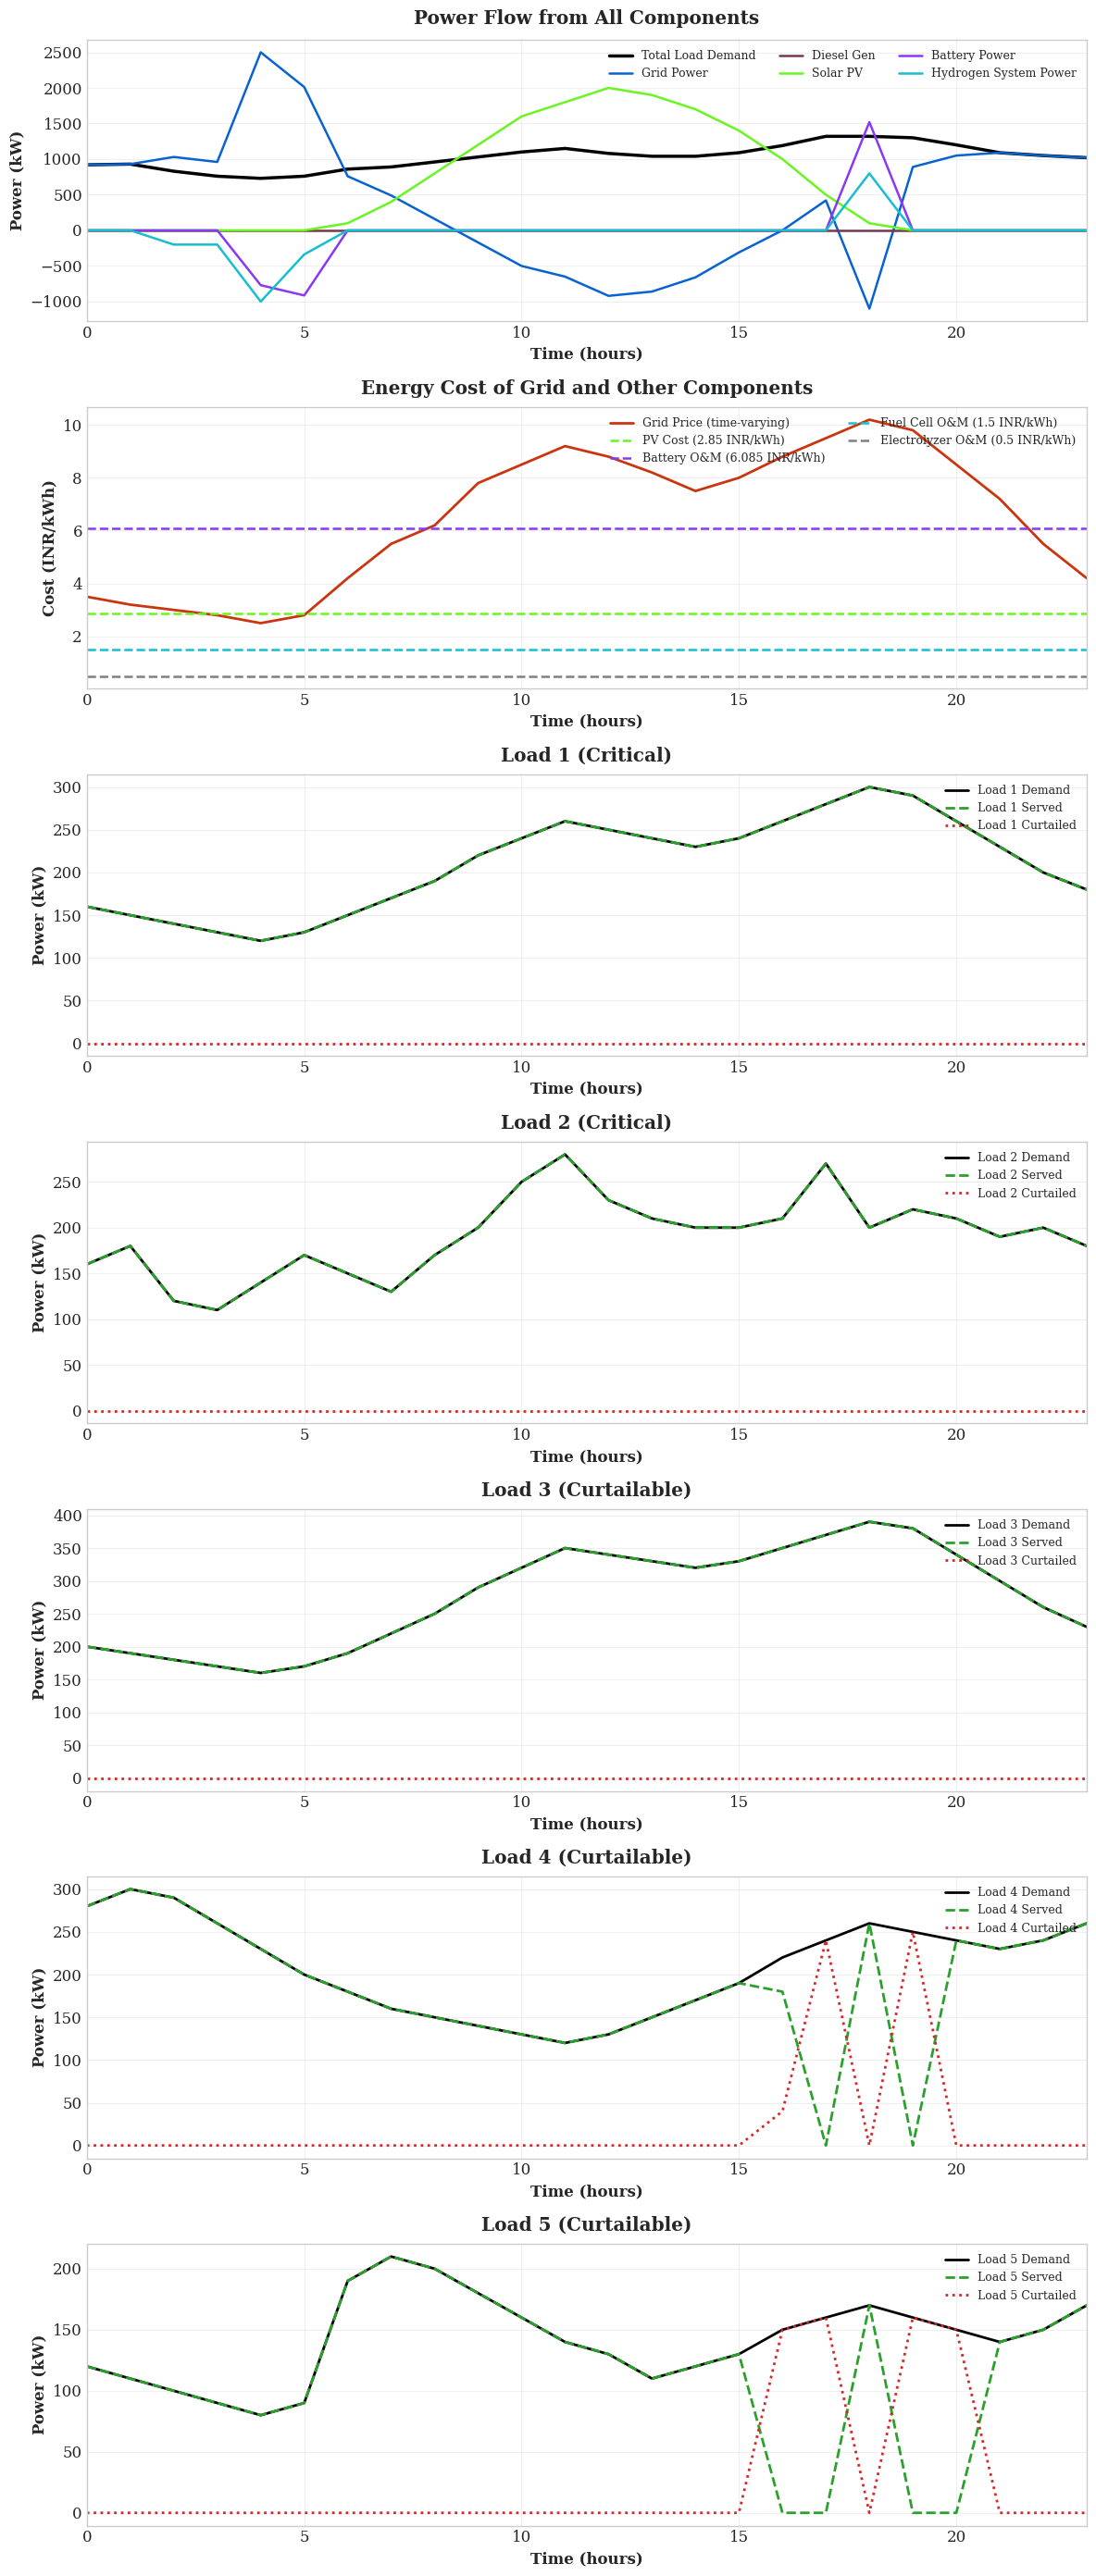


                      ENERGY SYSTEM SUMMARY REPORT
Optimization Period: 1 day(s)
Time Resolution: 60 minutes
Total Time Steps: 24

LOAD ANALYSIS:
  Total Load Demand:         24660.0 kWh
  Total Load Served:         23510.0 kWh (95.3%)
  Total Load Curtailed:       1150.0 kWh

  Load 1 [CRITICAL]:
     Demand:      5020.0 kWh
     Served:      5020.0 kWh (100.0%)
     Curtailed:      0.0 kWh

  Load 2 [CRITICAL]:
     Demand:      4580.0 kWh
     Served:      4580.0 kWh (100.0%)
     Curtailed:      0.0 kWh

  Load 3 [DR (Curtailable)]:
     Demand:      6630.0 kWh
     Served:      6630.0 kWh (100.0%)
     Curtailed:      0.0 kWh

  Load 4 [DR (Curtailable)]:
     Demand:      5020.0 kWh
     Served:      4490.0 kWh (89.4%)
     Curtailed:    530.0 kWh

  Load 5 [DR (Curtailable)]:
     Demand:      3410.0 kWh
     Served:      2790.0 kWh (81.8%)
     Curtailed:    620.0 kWh

GRID ANALYSIS:
  Grid Import:               15282.5 kWh
  Grid Export:                5169.2 kWh

DIESEL GENE

In [23]:
# %%
import matplotlib.pyplot as plt
from pulp import *
import numpy as np
import pandas as pd


# %%
# =============================================================================
# USER CONFIGURABLE PARAMETERS
# =============================================================================


# Optimization Time Parameters
num_days = 1                    # Number of days to optimize
time_resolution_minutes = 60    # Time step in minutes (e.g., 15, 30, 60)

# System connection parameters
grid_connection = 2500      # Grid connection capacity [kW]
solar_connection = 2000     # Solar connection capacity [kW]
battery_capacity = 40000    # Battery capacity [Ah]
battery_voltage = 100       # Battery voltage [V]
diesel_capacity = 2200      # Diesel generator capacity [kW]
fuel_price = 90             # INR per liter

# Hydrogen System Parameters
electrolyzer_capacity = 1000  # Max power consumption of the electrolyzer [kW]
fuel_cell_capacity = 1000      # Max power generation of the fuel cell [kW]
h2_tank_capacity = 100        # Hydrogen storage tank capacity [kg]
fuel_cell_efficiency_percent = 0.60 # Fuel cell DC electrical efficiency (60%)

# Cost parameters
pv_energy_cost = 2.85               # PV energy cost [INR/kWh]
battery_om_cost = 6.085             # Battery O&M cost [INR/kWh]
fuel_cell_om_cost = 1.5             # Fuel cell O&M cost [INR/kWh]
electrolyzer_om_cost = 0.5          # Electrolyzer O&M cost [INR/kWh]

# ============================
# CO2 EMISSION PARAMETERS
# ============================
co2_grid_import = 0.82
co2_diesel = 0.27
co2_battery_discharge = 0.02
co2_pv_used = 0.05
co2_fuel_cell = 0.0
co2_electrolyzer = 0.0

# ==== Curtailment penalties per non-critical load ====
curtail_penalty = {
    3: 18.0,   # INR/kWh (high priority)
    4: 8.5,    # INR/kWh (medium priority)
    5: 8.0     # INR/kWh (low priority)
}

# Weather condition selection
weather_condition = 1  # 1 = Sunny, 2 = Rainy

# Base total load and price profiles (24-hour)
# load_profile_24h = [800, 750, 700, 650, 600, 650, 750, 850, 950, 1100, 1200, 1300,
#                     1250, 1200, 1150, 1200, 1300, 1400, 1500, 1450, 1300, 1150, 1000, 900]

# ======================
# FIVE FIXED LOAD PROFILES (24h)
# ======================

# Critical Load 1 (Base hospital load)
load1_24h = [
 160,150,140,130,120,130,150,170,190,220,240,260,
 250,240,230,240,260,280,300,290,260,230,200,180
]

# Critical Load 2 (Server / IT)
load2_24h = [
 160,180,120,110,140,170,150,130,170,200,250,280,
 230,210,200,200,210,270,200,220,210,190,200,180
]

# DR Load 3 (High Priority – office lighting & HVAC)
load3_24h = [
 200,190,180,170,160,170,190,220,250,290,320,350,
 340,330,320,330,350,370,390,380,340,300,260,230
]

# DR Load 4 (Medium Priority – residential)
load4_24h = [
 280,300,290,260,230,200,180,160,150,140,130,120,130,150,170,190,220,240,260,
 250,240,230,240,260
]

# DR Load 5 (Low Priority – EV/Flexible)
load5_24h = [
 120,110,100,90,80,90,190,210,200,180,160,140,130,110,120,130,150,160,170,
 160,150,140,150,170,
]


price_profile_24h = [3.5, 3.2, 3.0, 2.8, 2.5, 2.8, 4.2, 5.5, 6.2, 7.8, 8.5, 9.2,
                     8.8, 8.2, 7.5, 8.0, 8.8, 9.5, 10.2, 9.8, 8.5, 7.2, 5.5, 4.2]



# =============================================================================
# FIXED PARAMETERS AND MODEL SETUP
# =============================================================================

step_size = time_resolution_minutes / 60.0
steps_per_hour = int(60 / time_resolution_minutes)
time_horizon = num_days * 24 * steps_per_hour


def upsample_profile(hourly_profile, steps_per_hour, num_days):
    """Upsample hourly profile using linear interpolation."""
    hourly_times = np.arange(len(hourly_profile))
    fine_times = np.linspace(0, len(hourly_profile) - 1,
                             len(hourly_profile) * steps_per_hour)
    upsampled_single_day = np.interp(fine_times, hourly_times, hourly_profile).tolist()
    return upsampled_single_day * num_days



# Central physical constant
H2_LHV = 33.3  # kWh/kg

# Diesel generator parameters
diesel_min_power = 0.1 * diesel_capacity
diesel_max_power = diesel_capacity
fuel_slope, fuel_intercept = 0.18, 48

# Battery parameters
battery_storage_energy = (battery_capacity * battery_voltage) / 1000
battery_power = battery_storage_energy * 0.5

# Solar profiles
solar_profile_sunny = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 0.9,
                       1.0, 0.95, 0.85, 0.7, 0.5, 0.25, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0]
solar_profile_rainy = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25,
                       0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

if weather_condition == 1:
    solar_profile_base = solar_profile_sunny
    weather_type = "Sunny Day"
else:
    solar_profile_base = solar_profile_rainy
    weather_type = "Rainy Day"

# ==== Use new multi-load generator ====
load_ids = [1, 2, 3, 4, 5]
critical_loads = [1, 2]
dr_loads = [3, 4, 5]

# Upsample all five profiles
load_profiles = {
    1: upsample_profile(load1_24h, steps_per_hour, num_days),
    2: upsample_profile(load2_24h, steps_per_hour, num_days),
    3: upsample_profile(load3_24h, steps_per_hour, num_days),
    4: upsample_profile(load4_24h, steps_per_hour, num_days),
    5: upsample_profile(load5_24h, steps_per_hour, num_days),
}

# Total load (for plotting)
load_profile = [
    load_profiles[1][t] +
    load_profiles[2][t] +
    load_profiles[3][t] +
    load_profiles[4][t] +
    load_profiles[5][t]
    for t in range(time_horizon)
]

price_profile = upsample_profile(price_profile_24h, steps_per_hour, num_days)
solar_profile = upsample_profile(solar_profile_base, steps_per_hour, num_days)

# System Capacities
grid_max_power = grid_connection
solar_capacity = solar_connection
bess_charge_capacity = bess_discharge_capacity = battery_power
bess_energy_capacity = battery_storage_energy
bess_min_soc, bess_max_soc = 0.1, 0.9
bess_charge_efficiency, bess_discharge_efficiency = 0.95, 0.95

# Hydrogen System Parameters
h2_min_soc, h2_max_soc = 0.1, 0.9
fuel_cell_efficiency_kwh_per_kg = H2_LHV * fuel_cell_efficiency_percent
fc_conversion_rate = 1 / fuel_cell_efficiency_kwh_per_kg

# =============================================================================
# PIECEWISE LINEAR ELECTROLYZER PARAMETERS
# =============================================================================

P_break1_percent = 0.20
eff_at_break1 = 0.80
eff_at_break2 = 0.75

P_break1 = electrolyzer_capacity * P_break1_percent
P_break2 = electrolyzer_capacity

H2_at_break1 = (P_break1 * 1 * eff_at_break1) / H2_LHV
H2_at_break2 = (P_break2 * 1 * eff_at_break2) / H2_LHV

slope_s1 = H2_at_break1 / P_break1 if P_break1 > 0 else 0
slope_s2 = (H2_at_break2 - H2_at_break1) / (P_break2 - P_break1) if (P_break2 - P_break1) > 0 else 0

width_s1 = P_break1
width_s2 = P_break2 - P_break1

# =============================================================================
# OPTIMIZATION SETUP
# =============================================================================

bess_min_level, bess_max_level = bess_min_soc * bess_energy_capacity, bess_max_soc * bess_energy_capacity
h2_min_level, h2_max_level = h2_min_soc * h2_tank_capacity, h2_max_soc * h2_tank_capacity

model = LpProblem('Energy_System_Optimization', LpMinimize)
T = range(time_horizon)

# Decision Variables
P_grid = {t: LpVariable(f"P_grid_{t}", -grid_max_power, grid_max_power) for t in T}
P_diesel = {t: LpVariable(f"P_diesel_{t}", 0, diesel_max_power) for t in T}
z_diesel = {t: LpVariable(f"z_diesel_{t}", cat='Binary') for t in T}
F_diesel = {t: LpVariable(f"F_diesel_{t}", 0) for t in T}
P_charge = {t: LpVariable(f"P_charge_{t}", 0, bess_charge_capacity) for t in T}
P_discharge = {t: LpVariable(f"P_discharge_{t}", 0, bess_discharge_capacity) for t in T}
E_battery = {t: LpVariable(f"E_battery_{t}", bess_min_level, bess_max_level) for t in T}
z_bess = {t: LpVariable(f"z_bess_{t}", cat='Binary') for t in T}
P_pv_used = {t: LpVariable(f"P_pv_used_{t}", 0) for t in T}
P_solar_curt = {t: LpVariable(f"P_solar_curt_{t}", 0) for t in T}

# Hydrogen system variables
P_elec = {t: LpVariable(f"P_elec_{t}", 0, electrolyzer_capacity) for t in T}
P_fc = {t: LpVariable(f"P_fc_{t}", 0, fuel_cell_capacity) for t in T}
E_h2 = {t: LpVariable(f"E_h2_{t}", h2_min_level, h2_max_level) for t in T}
z_h2 = {t: LpVariable(f"z_h2_{t}", cat='Binary') for t in T}

# Piecewise electrolyzer
P_elec_s1 = {t: LpVariable(f"P_elec_s1_{t}", 0, width_s1) for t in T}
P_elec_s2 = {t: LpVariable(f"P_elec_s2_{t}", 0, width_s2) for t in T}
z_elec_s2 = {t: LpVariable(f"z_elec_s2_{t}", cat='Binary') for t in T}
H_produced = {t: LpVariable(f"H_produced_{t}", 0) for t in T}

# Served / curtailed loads
P_served = {(i, t): LpVariable(f"P_served_L{i}_{t}", 0) for i in load_ids for t in T}
P_curt = {(i, t): LpVariable(f"P_curt_L{i}_{t}", 0) for i in dr_loads for t in T}

# Binary flag: is there any curtailment at time t ? (Option B)
M_curt = sum(max(load_profiles[i]) for i in dr_loads)  # big-M for total curtailable load
z_curt = {t: LpVariable(f"z_curt_{t}", cat='Binary') for t in T}

# =============================================================================
# CONSTRAINTS
# =============================================================================

# Load constraints
for t in T:
    # Critical loads: must be fully served
    for i in critical_loads:
        model += P_served[(i, t)] == load_profiles[i][t], f"crit_load_{i}_served_{t}"
    # Non-critical: served + curtailed = demand
    for i in dr_loads:
        model += P_served[(i, t)] + P_curt[(i, t)] == load_profiles[i][t], f"dr_load_{i}_balance_{t}"

# Option B: Forbid grid export when any curtailment occurs at time t
for t in T:
    # If there is any curtailment -> z_curt[t] must be 1
    model += lpSum(P_curt[(i, t)] for i in dr_loads) <= M_curt * z_curt[t], f"curt_indicator_{t}"

    # If z_curt[t] = 1 (curtailment), then P_grid[t] >= 0  (no export)
    # If z_curt[t] = 0, this constraint relaxes to P_grid[t] >= -grid_max_power (normal bound)
    model += P_grid[t] >= -grid_max_power * (1 - z_curt[t]), f"no_export_when_curt_{t}"


# Power balance
for t in T:
    total_served_load = sum(P_served[(i, t)] for i in load_ids)
    supply = P_pv_used[t] + P_diesel[t] + P_discharge[t] + P_grid[t] + P_fc[t]
    demand = total_served_load + P_charge[t] + P_elec[t]
    model += (supply == demand), f"power_balance_{t}"

# Solar
for t in T:
    solar_available = solar_profile[t] * solar_capacity
    model += P_pv_used[t] + P_solar_curt[t] == solar_available, f"pv_balance_{t}"

# Diesel
for t in T:
    model += P_diesel[t] >= diesel_min_power * z_diesel[t], f"diesel_min_{t}"
    model += P_diesel[t] <= diesel_max_power * z_diesel[t], f"diesel_max_{t}"
    model += F_diesel[t] >= fuel_slope * P_diesel[t] + fuel_intercept * z_diesel[t], f"fuel_cons_{t}"

# Battery
initial_battery_level = 0.5 * bess_energy_capacity
model += E_battery[0] == initial_battery_level
for t in T:
    if t < time_horizon - 1:
        model += (E_battery[t+1] == E_battery[t] +
                  step_size * (P_charge[t] * bess_charge_efficiency -
                               P_discharge[t] * (1 / bess_discharge_efficiency))), f"battery_dynamics_{t}"
    model += P_charge[t] <= bess_charge_capacity * (1 - z_bess[t]), f"charge_limit_{t}"
    model += P_discharge[t] <= bess_discharge_capacity * z_bess[t], f"discharge_max_{t}"

model += (initial_battery_level == E_battery[time_horizon-1] +
          step_size * (P_charge[time_horizon-1] * bess_charge_efficiency -
                       P_discharge[time_horizon-1] * (1 / bess_discharge_efficiency))), "final_battery_level_cyclic"

# Hydrogen system
initial_h2_level = 0.5 * h2_tank_capacity
model += E_h2[0] == initial_h2_level

for t in T:
    model += P_elec[t] == P_elec_s1[t] + P_elec_s2[t], f"elec_power_sum_{t}"
    model += H_produced[t] == (P_elec_s1[t] * slope_s1) + (P_elec_s2[t] * slope_s2), f"h2_production_calc_{t}"
    model += P_elec_s1[t] >= width_s1 * z_elec_s2[t], f"elec_s1_fill_before_s2_{t}"
    model += P_elec_s2[t] <= width_s2 * z_elec_s2[t], f"elec_s2_activation_{t}"
    model += P_fc[t] <= fuel_cell_capacity * z_h2[t], f"fc_limit_{t}"
    model += P_elec[t] <= electrolyzer_capacity * (1 - z_h2[t]), f"elec_limit_{t}"

    if t < time_horizon - 1:
        model += (E_h2[t+1] == E_h2[t] + H_produced[t] * step_size -
                  (P_fc[t] * step_size * fc_conversion_rate)), f"h2_dynamics_{t}"

model += (E_h2[0] == E_h2[time_horizon-1] +
          H_produced[time_horizon-1] * step_size -
          (P_fc[time_horizon-1] * step_size * fc_conversion_rate)), "final_h2_level_cyclic"

# =============================================================================
# OBJECTIVE FUNCTION
# =============================================================================

cost_components = []
for t in T:
    cost_components.extend([
        step_size * price_profile[t] * P_grid[t],
        fuel_price * F_diesel[t],
        step_size * pv_energy_cost * P_pv_used[t],
        step_size * battery_om_cost * P_discharge[t],
        step_size * fuel_cell_om_cost * P_fc[t],
        step_size * electrolyzer_om_cost * P_elec[t]
    ])
    # curtailment penalties
    for i in dr_loads:
        cost_components.append(step_size * curtail_penalty[i] * P_curt[(i, t)])

model += sum(cost_components)

# =============================================================================
# SOLVE AND ANALYZE
# =============================================================================
print("\nSolving MILP optimization model with piecewise efficiency (Cost minimization)...")
print(f"Optimization horizon: {num_days} day(s) with {time_resolution_minutes}-minute resolution")
print(f"Total time steps: {time_horizon}")
solver = PULP_CBC_CMD(msg=0, timeLimit=180, gapRel=0.01)
model.solve()
print(f"Optimal solution found! Total cost: {value(model.objective):.2f} INR")

# Post-processing
h2_levels_for_plot = []
for t in T:
    h2_at_end_of_t = value(E_h2[t]) + value(H_produced[t]) * step_size - value(P_fc[t]) * step_size * fc_conversion_rate
    h2_levels_for_plot.append(h2_at_end_of_t)

time_axis = [t * step_size for t in range(time_horizon)]

# Build per-load series
load_demand_total = []
load_curt_total = []
load_demand_by_i = {i: [] for i in load_ids}
load_served_by_i = {i: [] for i in load_ids}
load_curt_by_i = {i: [] for i in load_ids}

for t in T:
    total_demand_t = 0.0
    total_curt_t = 0.0
    for i in load_ids:
        demand_it = load_profiles[i][t]
        served_it = value(P_served[(i, t)])
        if i in dr_loads:
            curt_it = value(P_curt[(i, t)])
        else:
            curt_it = 0.0

        load_demand_by_i[i].append(demand_it)
        load_served_by_i[i].append(served_it)
        load_curt_by_i[i].append(curt_it)

        total_demand_t += demand_it
        total_curt_t += curt_it

    load_demand_total.append(total_demand_t)
    load_curt_total.append(total_curt_t)

results_data = {
    'Time_Step': list(range(time_horizon)),
    'Time_Hours': time_axis,
    'Load_Demand': load_demand_total,
    'Price': price_profile,
    'Grid_Power': [value(P_grid[t]) for t in T],
    'Load_Curtailed': load_curt_total,
    'Diesel_Power': [value(P_diesel[t]) for t in T],
    'Fuel_Cost': [fuel_price * value(F_diesel[t]) for t in T],
    'Charge_Power': [value(P_charge[t]) for t in T],
    'Discharge_Power': [value(P_discharge[t]) for t in T],
    'Net_Battery_Power': [value(P_discharge[t]) - value(P_charge[t]) for t in T],
    'Battery_Level': [value(E_battery[t]) for t in T],
    'Battery_SOC': [value(E_battery[t]) / bess_energy_capacity * 100 for t in T],
    'Solar_Available': [solar_profile[t] * solar_capacity for t in T],
    'PV_Used': [value(P_pv_used[t]) for t in T],
    'Solar_Curtailed': [value(P_solar_curt[t]) for t in T],
    'Electrolyzer_Power': [value(P_elec[t]) for t in T],
    'Fuel_Cell_Power': [value(P_fc[t]) for t in T],
    'Net_H2_Power': [value(P_fc[t]) - value(P_elec[t]) for t in T],
    'H2_Level': h2_levels_for_plot,
    'H2_SOC': [level / h2_tank_capacity * 100 for level in h2_levels_for_plot],
    'Fuel_Cell_OM_Cost': [fuel_cell_om_cost * value(P_fc[t]) for t in T],
    'H2_Produced_kg': [value(H_produced[t]) for t in T]
}

for i in load_ids:
    results_data[f'Load{i}_Demand'] = load_demand_by_i[i]
    results_data[f'Load{i}_Served'] = load_served_by_i[i]
    results_data[f'Load{i}_Curtailed'] = load_curt_by_i[i]

results_df = pd.DataFrame(results_data)

# =============================================================================
# VISUALIZATION: 7 SUBPLOTS
#   1) Power flows from all components
#   2) Time-varying & constant energy costs (INR/kWh)
#   3–7) Load 1–5: demand, served, curtailed
# =============================================================================

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold'
})

colors = {
    'load':    "#010103",
    'grid':    "#0863D1",
    'diesel':  "#72394F",
    'battery': "#8938F3",
    'solar':   "#6BF520",
    'h2':      "#17becf",
    'served':  "#2ca02c",
    'curt':    "#d62728",
    'price':   "#CA3510"
}

time_hours = results_df["Time_Hours"]

fig, axes = plt.subplots(7, 1, figsize=(12, 28), sharex=True)

# ================================================================
# Subplot 1 — Power Flow from All Components
# ================================================================
ax0 = axes[0]

ax0.plot(time_hours, results_df['Load_Demand'],
         color=colors['load'], linewidth=2.5, label="Total Load Demand")
ax0.plot(time_hours, results_df['Grid_Power'],
         color=colors['grid'], linewidth=1.8, label="Grid Power")
ax0.plot(time_hours, results_df['Diesel_Power'],
         color=colors['diesel'], linewidth=1.8, label="Diesel Gen")
ax0.plot(time_hours, results_df['PV_Used'],
         color=colors['solar'], linewidth=1.8, label="Solar PV")
ax0.plot(time_hours, results_df['Net_Battery_Power'],
         color=colors['battery'], linewidth=1.8, label="Battery Power")
ax0.plot(time_hours, results_df['Net_H2_Power'],
         color=colors['h2'], linewidth=1.8, label="Hydrogen System Power")

ax0.set_title("Power Flow from All Components", pad=12)
ax0.set_ylabel("Power (kW)")
ax0.set_xlabel("Time (hours)")
ax0.grid(True, alpha=0.3)
ax0.legend(fontsize=9, ncol=3, loc='upper right')
ax0.set_xlim(time_hours.min(), time_hours.max())
ax0.tick_params(axis='x', labelbottom=True)

# ================================================================
# Subplot 2 — Time-varying & Constant Energy Costs (INR/kWh)
# ================================================================
ax1 = axes[1]

# Time-varying grid price (already in results_df['Price'])
ax1.plot(time_hours, results_df["Price"],
         color=colors['price'], linewidth=2.0,
         label="Grid Price (time-varying)")

# Constant component costs over time
ax1.plot(time_hours, [pv_energy_cost] * len(time_hours),
         color=colors['solar'], linestyle='--', linewidth=1.8,
         label=f"PV Cost ({pv_energy_cost} INR/kWh)")

ax1.plot(time_hours, [battery_om_cost] * len(time_hours),
         color=colors['battery'], linestyle='--', linewidth=1.8,
         label=f"Battery O&M ({battery_om_cost} INR/kWh)")

ax1.plot(time_hours, [fuel_cell_om_cost] * len(time_hours),
         color=colors['h2'], linestyle='--', linewidth=1.8,
         label=f"Fuel Cell O&M ({fuel_cell_om_cost} INR/kWh)")

ax1.plot(time_hours, [electrolyzer_om_cost] * len(time_hours),
         color='gray', linestyle='--', linewidth=1.8,
         label=f"Electrolyzer O&M ({electrolyzer_om_cost} INR/kWh)")

ax1.set_title("Energy Cost of Grid and Other Components", pad=10)
ax1.set_ylabel("Cost (INR/kWh)")
ax1.set_xlabel("Time (hours)")
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=9, ncol=2, loc='upper right')
ax1.set_xlim(time_hours.min(), time_hours.max())
ax1.tick_params(axis='x', labelbottom=True)

# ================================================================
# Helper function for Load Subplots (3–7)
# ================================================================
def plot_load(ax, load_id, is_critical=False):
    ax.plot(time_hours, results_df[f"Load{load_id}_Demand"],
            color=colors['load'], linewidth=2,
            label=f"Load {load_id} Demand")

    ax.plot(time_hours, results_df[f"Load{load_id}_Served"],
            color=colors['served'], linestyle='--', linewidth=2,
            label=f"Load {load_id} Served")

    ax.plot(time_hours, results_df[f"Load{load_id}_Curtailed"],
            color=colors['curt'], linestyle=':', linewidth=2,
            label=f"Load {load_id} Curtailed")

    title = f"Load {load_id} (Critical)" if is_critical else f"Load {load_id} (Curtailable)"
    ax.set_title(title, pad=10)

    ax.set_ylabel("Power (kW)")
    ax.set_xlabel("Time (hours)")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(time_hours.min(), time_hours.max())
    ax.legend(fontsize=9, loc='upper right')
    ax.tick_params(axis='x', labelbottom=True)

# ================================================================
# Subplots 3–7 — Loads 1–5 vs Time
# ================================================================
plot_load(axes[2], 1, is_critical=True)
plot_load(axes[3], 2, is_critical=True)
plot_load(axes[4], 3, is_critical=False)
plot_load(axes[5], 4, is_critical=False)
plot_load(axes[6], 5, is_critical=False)

plt.tight_layout()
plt.show()


# =============================================================================
# SUMMARY REPORT (Updated for 5-Load Prioritization + Curtailment)
# =============================================================================

print("\n" + "="*65)
print("                      ENERGY SYSTEM SUMMARY REPORT")
print("="*65)
print(f"Optimization Period: {num_days} day(s)")
print(f"Time Resolution: {time_resolution_minutes} minutes")
print(f"Total Time Steps: {time_horizon}")

# ------------------------------------------------------------
# LOAD ANALYSIS
# ------------------------------------------------------------
total_load_demand = sum(results_df["Load_Demand"]) * step_size
total_load_served = total_load_demand - sum(results_df["Load_Curtailed"]) * step_size

print("\nLOAD ANALYSIS:")
print(f"  Total Load Demand:       {total_load_demand:9.1f} kWh")
print(f"  Total Load Served:       {total_load_served:9.1f} kWh "
      f"({total_load_served/total_load_demand*100:.1f}%)")
print(f"  Total Load Curtailed:    {total_load_demand - total_load_served:9.1f} kWh\n")

# Per-load breakdown
for i in load_ids:
    served = sum(results_df[f"Load{i}_Served"]) * step_size
    curt   = sum(results_df[f"Load{i}_Curtailed"]) * step_size
    demand = served + curt
    load_type = "CRITICAL" if i in critical_loads else "DR (Curtailable)"
    print(f"  Load {i} [{load_type}]:")
    print(f"     Demand:   {demand:9.1f} kWh")
    print(f"     Served:   {served:9.1f} kWh ({served/demand*100:.1f}%)")
    print(f"     Curtailed:{curt:9.1f} kWh\n")

# ------------------------------------------------------------
# GRID ANALYSIS
# ------------------------------------------------------------
grid_import = sum(max(0, g) for g in results_df["Grid_Power"]) * step_size
grid_export = sum(max(0, -g) for g in results_df["Grid_Power"]) * step_size

print("GRID ANALYSIS:")
print(f"  Grid Import:             {grid_import:9.1f} kWh")
print(f"  Grid Export:             {grid_export:9.1f} kWh\n")

# ------------------------------------------------------------
# DIESEL ANALYSIS
# ------------------------------------------------------------
diesel_energy = sum(results_df["Diesel_Power"]) * step_size
diesel_cost = sum(results_df["Fuel_Cost"])

print("DIESEL GENERATOR ANALYSIS:")
print(f"  Energy Generated:        {diesel_energy:9.1f} kWh")
print(f"  Fuel Cost:               {diesel_cost:9.1f} INR\n")

# ------------------------------------------------------------
# BATTERY ANALYSIS
# ------------------------------------------------------------
battery_charge = sum(results_df["Charge_Power"]) * step_size
battery_discharge = sum(results_df["Discharge_Power"]) * step_size

print("BATTERY ANALYSIS:")
print(f"  Energy Charged:          {battery_charge:9.1f} kWh")
print(f"  Energy Discharged:       {battery_discharge:9.1f} kWh")
print(f"  Battery Round Trip Δ:    {battery_discharge-battery_charge:9.1f} kWh\n")

# ------------------------------------------------------------
# SOLAR ANALYSIS
# ------------------------------------------------------------
solar_available = sum(results_df["Solar_Available"]) * step_size
solar_used = sum(results_df["PV_Used"]) * step_size
solar_curt = sum(results_df["Solar_Curtailed"]) * step_size

print("SOLAR ANALYSIS:")
print(f"  Solar Available:         {solar_available:9.1f} kWh")
print(f"  Solar Used:              {solar_used:9.1f} kWh "
      f"({solar_used/solar_available*100:.1f}%)")
print(f"  Solar Curtailed:         {solar_curt:9.1f} kWh\n")

# ------------------------------------------------------------
# HYDROGEN SYSTEM
# ------------------------------------------------------------
elec_energy = sum(results_df["Electrolyzer_Power"]) * step_size
fc_energy = sum(results_df["Fuel_Cell_Power"]) * step_size
h2_produced = sum(results_df["H2_Produced_kg"]) * step_size
h2_consumed = fc_energy * fc_conversion_rate
fc_om_cost_total = sum(results_df["Fuel_Cell_OM_Cost"]) * step_size

round_trip = (fc_energy / elec_energy * 100) if elec_energy > 0 else 0

print("HYDROGEN SYSTEM ANALYSIS:")
print(f"  Energy to Electrolyzer:  {elec_energy:9.1f} kWh")
print(f"  Energy from Fuel Cell:   {fc_energy:9.1f} kWh")
print(f"  H2 Produced:             {h2_produced:9.3f} kg")
print(f"  H2 Consumed:             {h2_consumed:9.3f} kg")
print(f"  Round Trip Efficiency:   {round_trip:9.1f}%\n")

# ------------------------------------------------------------
# CO₂ EMISSIONS
# ------------------------------------------------------------
co2_grid  = sum(co2_grid_import       * max(0, value(P_grid[t]))      * step_size for t in T)
co2_dsl   = sum(co2_diesel            * value(P_diesel[t])            * step_size for t in T)
co2_batt  = sum(co2_battery_discharge * value(P_discharge[t])         * step_size for t in T)
co2_pv    = sum(co2_pv_used           * value(P_pv_used[t])           * step_size for t in T)
co2_fc    = sum(co2_fuel_cell         * value(P_fc[t])                * step_size for t in T)
co2_elec  = sum(co2_electrolyzer      * value(P_elec[t])              * step_size for t in T)

total_co2 = co2_grid + co2_dsl + co2_batt + co2_pv + co2_fc + co2_elec

print("CO₂ EMISSIONS ANALYSIS:")
print(f"  Grid Emissions:          {co2_grid:9.2f} kg")
print(f"  Diesel Emissions:        {co2_dsl:9.2f} kg")
print(f"  Battery Emissions:       {co2_batt:9.2f} kg")
print(f"  PV Emissions:            {co2_pv:9.2f} kg")
print(f"  Fuel Cell Emissions:     {co2_fc:9.2f} kg")
print(f"  Electrolyzer Emissions:  {co2_elec:9.2f} kg")
print(f"  -------------------------------------------")
print(f"  TOTAL CO₂ EMISSIONS:     {total_co2:9.2f} kg")
print(f"  Emissions per kWh:       {total_co2/total_load_served:9.4f} kg/kWh\n")

# ------------------------------------------------------------
# COST BREAKDOWN
# ------------------------------------------------------------
grid_cost = sum(results_df["Grid_Power"][t] * results_df["Price"][t] * step_size for t in T)
solar_cost_total = solar_used * pv_energy_cost
battery_cost_total = battery_discharge * battery_om_cost
electrolyzer_cost_total = elec_energy * electrolyzer_om_cost

curt_cost_total = sum(
    sum(results_df[f"Load{i}_Curtailed"]) * step_size * curtail_penalty[i]
    for i in dr_loads
)

print("COST BREAKDOWN:")
print(f"  Grid Cost:               {grid_cost:9.2f} INR")
print(f"  Diesel Fuel Cost:        {diesel_cost:9.2f} INR")
print(f"  Solar Cost:              {solar_cost_total:9.2f} INR")
print(f"  Battery O&M Cost:        {battery_cost_total:9.2f} INR")
print(f"  Electrolyzer O&M Cost:   {electrolyzer_cost_total:9.2f} INR")
print(f"  Fuel Cell O&M Cost:      {fc_om_cost_total:9.2f} INR")
print(f"  Curtailment Penalties:   {curt_cost_total:9.2f} INR")
print(f"  -------------------------------------------")
print(f"  TOTAL COST:              {value(model.objective):9.2f} INR")
print(f"  Cost per kWh Served:     {value(model.objective)/total_load_served:9.2f} INR/kWh\n")

# ------------------------------------------------------------
# SYSTEM CONFIGURATION
# ------------------------------------------------------------
print("SYSTEM CONFIGURATION:")
print("  ✓ Grid Connection")
print("  ✓ Diesel Generator")
print("  ✓ Battery Energy Storage System")
print("  ✓ Solar PV System")
print("  ✓ Hydrogen System (Electrolyzer + Fuel Cell)")
print(f"  Weather Profile: {weather_type}")
print("="*65)



In [24]:
violations = 0
for t in T:
    if results_df["Grid_Power"][t] < -1e-3 and results_df["Load_Curtailed"][t] > 1e-3:
        violations += 1
print("Export+Curtailment steps:", violations)


Export+Curtailment steps: 0
